In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn

In [3]:
datapath = Path("../data/stanford-dogs-dataset/")

In [4]:
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
sample_df = pd.read_csv(datapath/'sample_train.csv')

In [5]:
train_df.shape, test_df.shape, sample_df.shape

((12000, 2), (8580, 2), (6000, 3))

In [6]:
# train_df.head()
# test_df.head()
# sample_df.head()

### Dataset

In [7]:
def read_image(filename): return PILImage.create(datapath/'images/Images'/filename)
def read_image_size(filename): return PILImage.create(datapath/'images/Images'/filename).shape

In [8]:
FAST = True

In [9]:
if FAST:
    filenames = sample_df['filename'].values
    labels = sample_df['label'].values
    fn2label = dict(zip(filenames, labels))
else:
    filenames = train_df['filenames'].values
    labels = train_df['labels'].values
    fn2label = dict(zip(filenames, labels))

In [10]:
def read_label(filename): return fn2label[filename]

In [11]:
valid_filenames = sample_df.query("split == 'valid'")['filename'].values

In [12]:
size,bs = 384,32

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [13]:
len(dls.train_ds), len(dls.valid_ds)

(4800, 1200)

In [14]:
# dls.show_batch()

### Modifications on ViT

In [15]:
from utils.custom_vit import *

In [16]:
# timm vit _encoder
arch = "vit_base_patch16_384"
_encoder = create_encoder(arch, pretrained=True, n_in=3)

In [17]:
# custom vit encoder with timm weights
encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
encoder.head = Identity()
encoder.load_state_dict(_encoder.state_dict());

In [18]:
# grad checkpointing
encoder = CheckpointVisionTransformer(encoder, 12)

In [19]:
# 1) Change Stride Size

patch_size,stride_size = 16,16

# new_patch_embed = PatchEmbed(size, patch_size, stride_size)
# new_patch_embed.proj.weight.data = encoder.vit_model.patch_embed.proj.weight.data
# new_patch_embed.proj.bias.data = encoder.vit_model.patch_embed.proj.bias.data
# encoder.vit_model.patch_embed = new_patch_embed

# 2) Interpolate Position Embeddings to new Number of Patches

# num_patches = ((size - patch_size + stride_size) // stride_size)**2 + 1

# pos_embed_data = encoder.vit_model.pos_embed.data
# new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], 
#                                    size=[num_patches, pos_embed_data.size(-1)], 
#                                    mode='nearest')[0]
# encoder.vit_model.pos_embed.data = new_pos_embed_data

3) Create Model

In [20]:
with torch.no_grad():
    out, attn_wgts = encoder(torch.randn(2,3,size,size))
    nf = out.size(1)
classifier = create_cls_module(nf, dls.c, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [21]:
class FGVCModel(Module):
    def __init__(self, encoder, classifier, return_attn_wgts=False):
        self.encoder = encoder
        self.classifier = classifier
        self.return_attn_wgts = return_attn_wgts
        
    def forward(self, x):
        cls_token,attn_wgts = self.encoder(x)
        if self.return_attn_wgts: return self.classifier(cls_token), attn_wgts, cls_token
        else:                     return self.classifier(cls_token)  

In [22]:
model = FGVCModel(encoder, classifier)

In [23]:
attn_wgts[0].shape

torch.Size([2, 12, 577, 577])

In [24]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=768, out_features=120, bias=True)
)

In [25]:
# def model_splitter(m): return L(m[0], m[1]).map(params)
def model_splitter(m): return L(m.encoder, m.classifier).map(params)

In [26]:
cbs = []
# if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, model, opt_func=ranger, cbs=cbs, metrics=[accuracy], splitter=model_splitter,
                loss_func=LabelSmoothingCrossEntropyFlat(0.1))
learn.to_fp16();

### Train for Warmup

In [27]:
# learn.lr_find()

In [28]:
# epochs = 2

# lr = 3e-3
# learn.freeze()
# learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

# lr /= 3 
# learn.unfreeze()
# learn.fit_one_cycle(int(epochs**2), lr_max=slice(lr/100, lr), pct_start=0.5)

# learn.save(f"{arch}_stride_{stride_size}_imsize_{size}")

In [29]:
learn.load(f"{arch}_stride_{stride_size}_imsize_384");

In [30]:
# learn.validate()

In [31]:
pretrained_vit_encoder = learn.model.encoder.vit_model

In [32]:
del learn, dls, model
torch.cuda.empty_cache()

### Multi Crop Dataset : 1 x (384 px whole image) + 2 x (448 px -> 112 px crops)

In [33]:
from utils.attention import *

In [34]:
size,bs = 448,16

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [35]:
from torch.utils.checkpoint import checkpoint
class FullImageEncoder(Module):
    "Encoder which takes whole image input then outputs attention weights + layer features"
    def __init__(self, pretrained_vit_encoder, nblocks=11, checkpoint_nchunks=2, return_attn_wgts=True):
                
        # initialize params with warm up model
        self.patch_embed = pretrained_vit_encoder.patch_embed
        self.cls_token = pretrained_vit_encoder.cls_token
        self.pos_embed = pretrained_vit_encoder.pos_embed
        self.pos_drop = pretrained_vit_encoder.pos_drop
        
        # until layer n-1, can be changed (memory trade-off)
        self.blocks = pretrained_vit_encoder.blocks[:nblocks]        
        
        # not needed now
#         self.norm = pretrained_vit_encoder.norm
        
        # gradient checkpointing
        self.checkpoint_nchunks = checkpoint_nchunks
        
        self.return_attn_wgts = return_attn_wgts
         
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # collect attn_wgts from all layers
        attn_wgts = []
        if self.return_attn_wgts:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,attn_wgt = checkpoint(blk, x)
                else:                         x,attn_wgt = blk(x)
                attn_wgts.append(attn_wgt)
            return x,attn_wgts
        
        else:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,_ = checkpoint(blk, x)
                else:                         x,_ = blk(x)
            return x
        
    def forward(self, x):
        return self.forward_features(x)

In [36]:
from fastai.vision.all import *

def generate_batch_attention_maps(attn_wgts, targ_sz=None, mode=None):
    "Generate attention flow maps with shape (targ_sz,targ_sz) from L layer attetion weights of transformer model"
    # Stack for all layers - BS x L x K x gx x gy
    att_mat = torch.stack(attn_wgts, dim=1)
    
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=2)
   
    # To account for residual connections, we add an identity matrix to the
    aug_att_mat = att_mat + torch.eye(att_mat.size(-1))[None,None,...].to(att_mat.device)
    
    # Re-normalize the weights.
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = aug_att_mat[:,0].clone()
    for n in range(1, aug_att_mat.size(1)): joint_attentions = torch.bmm(aug_att_mat[:,n], joint_attentions)

    # BS x (num_patches+1) -> BS x gx x gy
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    joint_attentions = joint_attentions[:,0,1:].view(joint_attentions.size(0),grid_size,grid_size)
    joint_attentions /= torch.amax(joint_attentions, dim=(-2,-1), keepdim=True)

    # Bilinear interpolation to target size
    if mode == 'bilinear':
        joint_attentions = F.interpolate(joint_attentions[None,...], 
                                         (targ_sz,targ_sz), 
                                         mode=mode, align_corners=True)[0]
    elif mode == 'nearest':
        joint_attentions = F.interpolate(joint_attentions[None,...], 
                                         (targ_sz,targ_sz), 
                                         mode=mode)[0]
    elif mode is None:
        joint_attentions = joint_attentions
    
    return joint_attentions

In [37]:
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [38]:
full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=11, checkpoint_nchunks=12).cuda()

In [39]:
xb_448, yb = dls.one_batch()

In [40]:
xb_384 = F.interpolate(xb_448, size=(384,384))

In [41]:
x_full, attn_wgts = full_image_encoder(xb_384)

In [59]:
attention_maps = to_detach(generate_batch_attention_maps(attn_wgts, None, mode=None))

In [60]:
targ_sz = 112
kernel_size = int(targ_sz//(384/attention_maps.size(-1)))
avgpool = nn.AvgPool2d(kernel_size=kernel_size, stride=1)

In [61]:
attention_map_scores = avgpool(attention_maps)

In [62]:
attention_map_scores.shape

torch.Size([16, 18, 18])

In [63]:
attention_map_scores_flat = attention_map_scores.view(attention_map_scores.size(0),-1)

In [64]:
attention_map_scores_flat.shape

torch.Size([16, 324])

In [65]:
sorted_values_idxs = torch.sort(attention_map_scores_flat, descending=True)

In [66]:
sorted_values, sorted_idxs = sorted_values_idxs.values.numpy(), sorted_values_idxs.indices.numpy()

In [120]:
num_bboxes = 2
scale = 384//attention_maps.size(-1)

batch_final_resized_coords = []

for _values, _idxs in zip(sorted_values, sorted_idxs):
    top_coords = []
    for score,idx in zip(_values, _idxs):
        div, mod = divmod(idx, attention_map_scores.size(-1))
        minr, minc, maxr, maxc = div, mod, div+kernel_size, mod+kernel_size
        top_coords += [[minr, minc, maxr, maxc, score]]

    top_coords = np.vstack(top_coords)
    top_nms_idxs = nms(top_coords, thresh=0.3)

    final_resized_coords = (top_coords[top_nms_idxs][:, :-1]*scale)[:num_bboxes]
    batch_final_resized_coords.append(final_resized_coords)

In [129]:
xb_384_decoded = dls.after_batch.decode(xb_384)

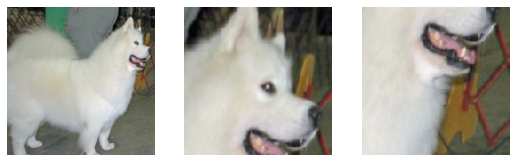

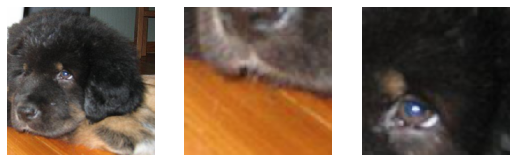

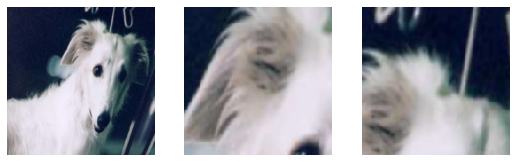

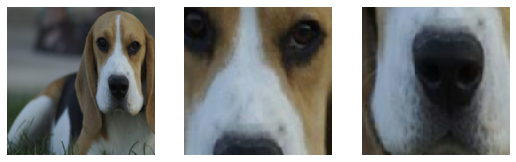

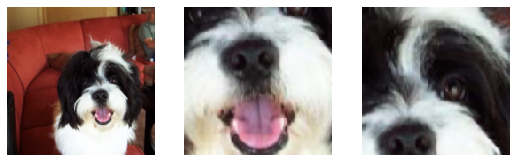

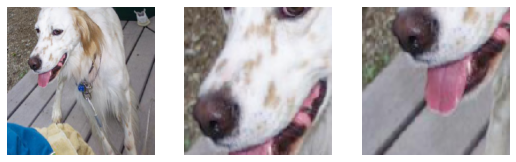

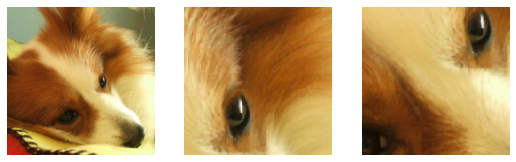

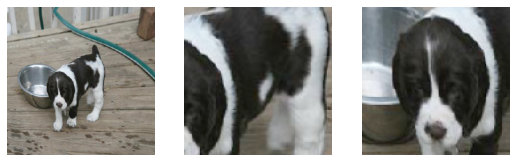

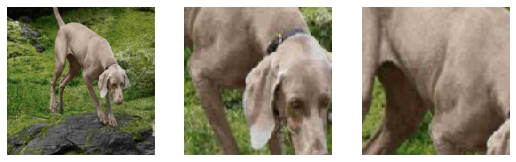

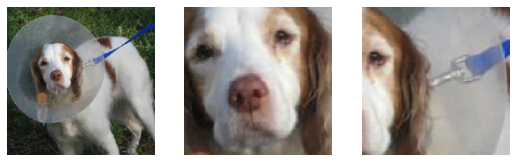

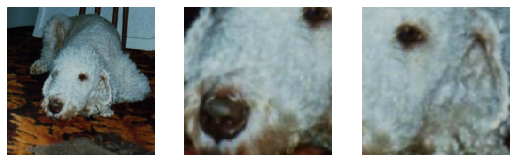

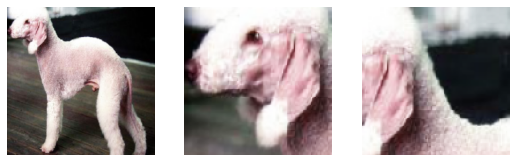

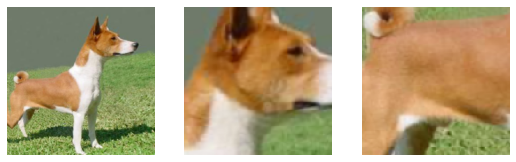

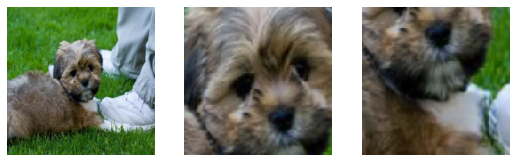

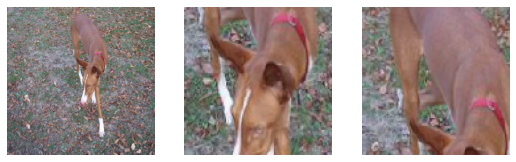

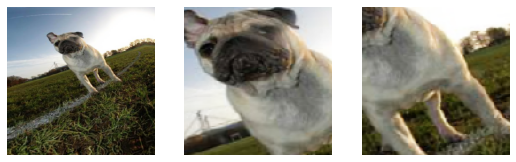

In [130]:
for i,coords in enumerate(batch_final_resized_coords):
    coord1, coord2 = coords.astype(int)
    
    im = xb_384_decoded[i]
    show_images([im, 
                 im[:, coord1[0]:coord1[2], coord1[1]:coord1[3]],
                 im[:, coord2[0]:coord2[2], coord2[1]:coord2[3]]])

In [70]:
torch.where(pooled[0] == (pooled[0]).max())

(tensor([0], device='cuda:0'), tensor([2], device='cuda:0'))

<AxesSubplot:>

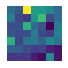

In [82]:
show_image(attention_maps[0, 0:7, 2:9])

<AxesSubplot:>

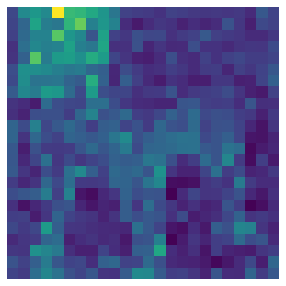

In [51]:
show_image(attention_maps[0], figsize=(5,5))

In [39]:
class STViT(Module):
    "Spatial Transformer-ViT Model"
    def __init__(self, pretrained_vit_encoder):
        
        self.full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=11, checkpoint_nchunks=12)
        self.st_model = SpatialTransfomerBlock()

        self.crop_image_encoder = deepcopy(self.full_image_encoder)
        self.crop_image_encoder.return_attn_wgts = False
        num_patches = 50
        # interpolate pos embed from 384 px -> 112 px
        pos_embed_data = self.crop_image_encoder.pos_embed.data
        new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], size=[num_patches, pos_embed_data.size(-1)])[0]
        self.crop_image_encoder.pos_embed.data = new_pos_embed_data
        
        self.final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
        self.norm = partial(nn.LayerNorm, eps=1e-6)(768)
        self.classifier = create_cls_module(768, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)
        
              
    def forward(self, xb_448):
        
        xb_384 = F.interpolate(xb_448, size=(384,384))
        x_full, attn_wgts = self.full_image_encoder(xb_384)

        attention_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()
        
        theta_crops = self.st_model(attention_maps)
        
#         del attn_wgts
#         torch.cuda.empty_cache()
        
        xb_112_crop1 = self.st_model.transform(xb_448.half(), theta_crops[:,0], targ_sz=112)
        xb_112_crop2 = self.st_model.transform(xb_448.half(), theta_crops[:,1], targ_sz=112)
        x_crop1 = self.crop_image_encoder(xb_112_crop1)
        x_crop2 = self.crop_image_encoder(xb_112_crop2)
        
        x = torch.cat([x_full, x_crop1, x_crop2], dim=1)

        
#         i = np.random.choice(range(len(xb_448)))
#         self.random_images = to_detach([xb_448[i].clone(),
#                                         xb_112_crop1[i].clone().float(), 
#                                         xb_112_crop2[i].clone().float()])
        
        x,_ = self.final_block(x)
        x = self.norm(x)[:,0]
        return self.classifier(x)

In [40]:
class CollectImages(Callback):
    run_train,run_valid=True,False
    def __init__(self):
        self.images = []
    
    def after_pred(self):
        if self.iter % 10 == 0:
            self.images.append([TensorImage(o) for o in self.learn.model.random_images])

### Train

In [41]:
# torch.autograd.set_detect_anomaly(True)

In [42]:
def model_splitter(m): return L(m.full_image_encoder, 
                                m.st_model, 
                                m.crop_image_encoder,
                                m.final_block, 
                                m.norm,
                                m.classifier).map(params)

In [43]:
stvit_model = STViT(pretrained_vit_encoder)

In [44]:
cbs = [CollectImages()]
# cbs = []
# if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, stvit_model, opt_func=ranger, cbs=cbs, metrics=[accuracy],
                splitter=model_splitter,
                loss_func=LabelSmoothingCrossEntropyFlat(0.1))
learn.to_fp16();

In [45]:
# learn.lr_find()

In [46]:
epochs = 2

lr = 3e-3
learn.freeze_to(1)
learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

lr /= 3 
learn.unfreeze()
learn.fit_one_cycle(int(epochs**2), lr_max=[lr/100, lr, lr, lr, lr, lr], pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,2.742869,1.869168,0.675833,01:48
1,1.202314,1.197686,0.885000,01:49


epoch,train_loss,valid_loss,accuracy,time
0,1.055235,1.185768,0.885000,03:10
1,1.101071,1.214655,0.879167,03:10
2,0.981565,1.148947,0.889167,03:09
3,0.875029,1.115198,0.899167,03:09


In [60]:
len(learn.collect_images.images)

180

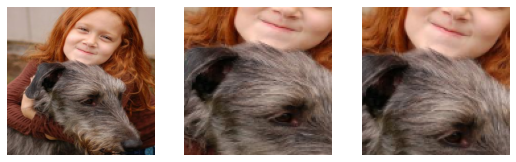

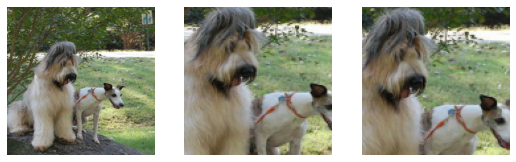

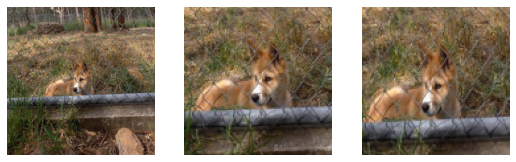

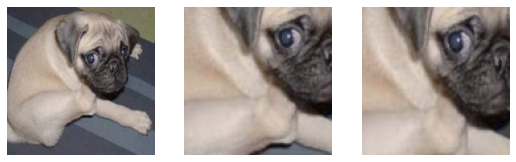

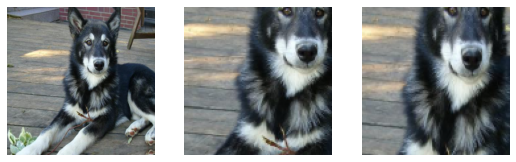

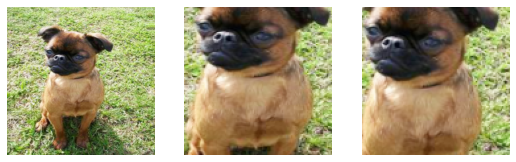

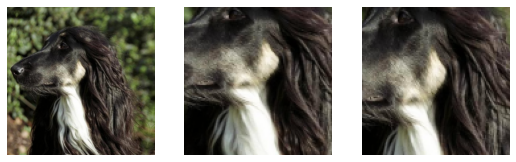

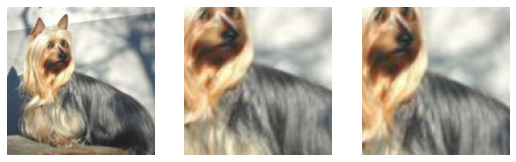

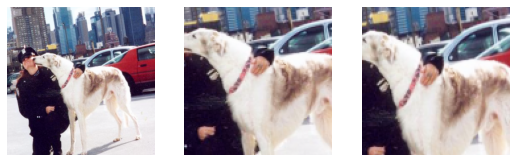

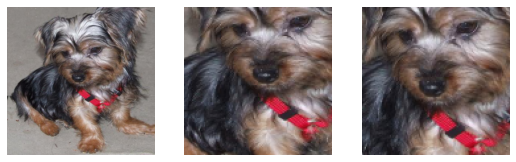

In [66]:
for images in learn.collect_images.images[20]:
    show_images([dls.after_batch.decode(o[None,...])[0] for o in images])